In [9]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [19]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time =  1

max_x = 3
n_train = 2 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_SHM_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[ 1.77946086 -1.01657554]
[ 0.10606167 -0.09011046]


In [21]:

test_starting_position = np.random.uniform(-max_x, max_x)
test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

print(test_starting_position)
print(test_starting_velocity)

test_data = get_SHM_data(time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])
for jitter in [1e-4]:
#    print("current jitter %s" %jitter)
    moi = get_GPR_model(get_MOI(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_model_future(moi, test_data, time_step)
    print(evaluate_moi[0])
    print(evaluate_model_grid(moi, 5, 40, SHM_dynamics))
    for invar_density in [40]: #np.arange(10, 30, 10):
            try:
                kernel = get_SHM_invariance(5, invar_density, jitter) #switch
                m = get_GPR_model(kernel, mean, data, 100)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_model_future(m, test_data, time_step)
                print(evaluate_invariance[0])
                print(evaluate_model_grid(m, 5, 40, SHM_dynamics))

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 

# %%

0.9514289103970004
0.20949306986376326
142, 
0.004991548427872833
7.057250004723301
167
0.003205274482438318
1.114867052819501


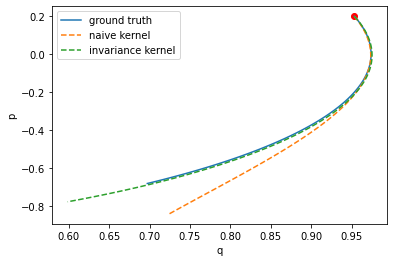

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="ground truth")
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='naive kernel')
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance kernel")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()

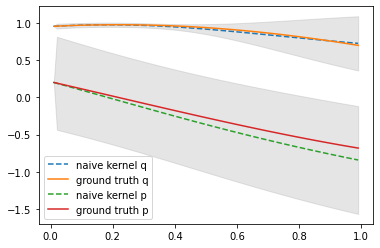

In [28]:
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
plt.plot(t,evaluate_moi[1][:,0],'--',label="naive kernel q")
plt.plot(t, test_data[0][:,0], label="ground truth q")
plt.fill_between(t,evaluate_moi[1][:,0]+1.96*np.sqrt(evaluate_moi[2][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[1][:,0]-1.96*np.sqrt(evaluate_moi[2][:,0]+moi.likelihood.variance.numpy()), color="grey", alpha=0.5)
plt.plot(t,evaluate_moi[1][:,1],'--',label="naive kernel p")
plt.plot(t, test_data[0][:,1], label="ground truth p" )
plt.fill_between(t,evaluate_moi[1][:,1]+1.96*np.sqrt(evaluate_moi[2][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[1][:,1]-1.96*np.sqrt(evaluate_moi[2][:,1]+moi.likelihood.variance.numpy()), color="grey", alpha=0.5)
plt.legend()


In [1]:
plt.plot(t,evaluate_invariance[1][:,0], '--', label="invariance kernel q")
plt.fill_between(t,evaluate_invariance[1][:,0]+1.96*np.sqrt(evaluate_invariance[2][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[1][:,0]-1.96*np.sqrt(evaluate_invariance[2][:,0]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],label="ground truth q")
plt.plot(t,evaluate_invariance[2][:,1], '--', label="invariance kernel p")
plt.plot(t, test_data[0][:,1],label="ground truth p")
plt.fill_between(t,evaluate_invariance[1][:,1]+1.96*np.sqrt(evaluate_invariance[2][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[1][:,1]-1.96*np.sqrt(evaluate_invariance[2][:,1]+m.likelihood.variance.numpy()), color="grey")
plt.xlabel("t")
plt.legend()

NameError: name 'plt' is not defined